<a href="https://colab.research.google.com/github/raklugrin01/DisasterTweetsRealVsFake/blob/main/DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#libraries for NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

!pip install chart_studio
!pip install textstat
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# File system manangement
import os
!pip install transformers
#Transformers
from transformers import BertTokenizer
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio

In [2]:
#lets import our dataset using pandas download from https://www.kaggle.com/c/nlp-getting-started/data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/nlp-getting-started/train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
#from above we can see that keyword and location columns of our data are missing values.
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#from above we can see that keyword and location columns of our data are missing values.
#we visualize the counts of our target column
data = data[['text','target']]
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),color=["red", "goldenrod"])
for dt in fig.data:
    dt["width"] = 0.4 #Change this value for bar widths
fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    xaxis_title="Targets",
    yaxis_title="Count",
    width  = 1000, 
    height = 600,
    showlegend=False
).show(renderer="colab")

pio.write_html(fig, file='figure1.html', auto_open=True)

In [7]:
from plotly.subplots import make_subplots
#we see that our data is quite balanced 
#analyzing length of words in a tweet according to its target value
word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))
word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))
fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
    go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=1
).add_trace(
    go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show(renderer='colab')

pio.write_html(fig, file='figure2.html', auto_open=True)

In [8]:
#from above we can see that number of words in the tweets ranges from 2 to 30
import plotly.figure_factory as ff
#now we will check average word length for both type of tweets
def avgwordlen(strlist):
  sum=[]
  for i in strlist:
    sum.append(len(i))
  return sum
avgword_len_dis = data[data['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
avgword_len_non_dis = data[data['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)
fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show(renderer='colab')

pio.write_html(fig, file='figure3.html', auto_open=True)

In [9]:
#it can be observed that the average word count for disaster tweets are found to be in the range(5-7.5)
# while for non-disaster tweets are in the range of (4-6).
# Creating sample corpus for further analysis.
def create_corpus(target):
  corpus = []
  for i in data[data['target']==target]['text'].str.split():
    for x in i:
      corpus.append(x)
  return corpus

In [10]:
# Analysing top stop words in text.
from collections import defaultdict

def analyze_stopwords(data,func,targetlist):
  values_list = []

  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
      dic[word] += 1
    
    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

  fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
  fig.add_trace(
    go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=1
  ).add_trace(
    go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=2
  ).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show(renderer='colab') 

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])

pio.write_html(fig, file='figure4.html', auto_open=True)

In [11]:
#The above Bar Charts displays the top 10 stop words in tweets where the occurs the most in both groups
# Anaysing Punctuations
from string import punctuation
def analyze_punctuations(data,func,targetlist):
  values_list = []
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
      if word in punctuation:
        dic[word] += 1 
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)
  fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
  fig.add_trace(
    go.Bar(x=values_list[0],y=values_list[1],marker=dict(color= 'rgba(196, 94, 255,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=1
  ).add_trace(
    go.Bar(x=values_list[2],y=values_list[3],marker=dict(color= 'rgba(255, 163, 102,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=2
  ).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show(renderer='colab') 

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

pio.write_html(fig, file='figure5.html', auto_open=True)

In [12]:
#  it is observed that the most occuring punctuations in both disaster/non-disaster tweets is '-'(350+) and '|'
#  while the least occuring for non-disaster are '%','/:','$','_' and for disaster tweets is '=>', ')'.
# Now let's clean the data
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_data(data):

    review =re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) #removal of url
    review =re.sub(r'<.*?>',' ',review) #removal of html tags
    # Match all digits in the string and replace them by empty string
    review = re.sub(r'[0-9]', '', review)
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = re.sub(r"\([^()]*\)", "", review)
    review = re.sub('@\S+', '', review)  # remove mentions
    review = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', review)  # remove punctuations
    review = review.lower() # Lowering all the words in text
    review = review.split()
    review = [lemmatizer.lemmatize(words) for words in review if words not in stopwords.words('english')] #Stemming
    review = [i for i in review if len(i)>2] # Removal of words with length<2
    review = ' '.join(review)
    return review

data["Cleaned_text"] = data["text"].apply(preprocess_data)

In [13]:
# # !pip install pyspellchecker
# from spellchecker import SpellChecker
# from tqdm import tqdm
# spell = SpellChecker()
# def correct_spell(text):
#     corrected_text = []
#     mispelled_words = spell.unknown(text.split())
#     for word in tqdm(text.split()):
#         if word in mispelled_words:
#             corrected_text.append(spell.correction(text))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# data["Cleaned_text"] = data["Cleaned_text"].apply(lambda x: correct_spell(x))

In [14]:
data.head()

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [15]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
    

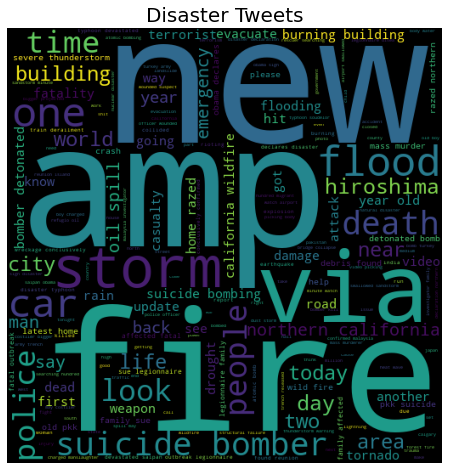

In [16]:
data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

wordcloud(data_disaster,"Disaster Tweets")

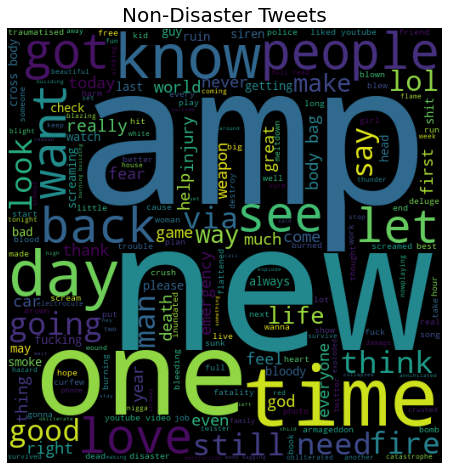

In [17]:
#we can see that most common words in disaster tweets are fire,storm,flood , police etc.
#now let's have a look on Non-Disaster tweets
wordcloud(data_non_disaster,"Non-Disaster Tweets")

In [18]:
#love,new,time etc are the most common words in wordcloud of Non-disaster tweets
#it appears that our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,
# resulting in false prediction.
# Now, we will further remove some confusing words from text based on above charts.

common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

In [19]:
# Now we will convert our cleaned text in numerical form as our model will only take numerical inputs
# BOW
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]
    

In [20]:
#analysing top 10 N-grams
common_uni = top_ngrams(data["Cleaned_text"],10,1)
common_bi = top_ngrams(data["Cleaned_text"],10,2)
common_tri = top_ngrams(data["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

In [21]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 20 Unigrams in Text", "Top 20 Bigrams in Text","Top 20 Trigrams in Text"))
  
fig.add_trace(
  go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],marker=dict(color= 'rgba(255, 170, 59,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=1
).add_trace(
  go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],marker=dict(color= 'rgba(89, 255, 147,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=2, col=1
).add_trace(
  go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],marker=dict(color= 'rgba(89, 153, 255,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=3, col=1
).update_layout(title_text="Visualization of Top 20 Unigrams, Bigrams and Trigrams",title_x=0.5,showlegend=False,width=1400,height=1600,).update_xaxes(tickangle=-90).show(renderer='colab')

pio.write_html(fig, file='figure6.html', auto_open=True)